## Load packages, modules, data and functions

### Load libraries, packages and modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
plt.style.use('fivethirtyeight')

from scipy import stats
from scipy.stats import skew

### Load the two datasets and combine them

In [4]:
# load train data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
#create a new column 'Is_train' to differentiate the training data from the testing data, 1 = training, 0 = testing
train_df['Is_train'] = 1
test_df['Is_train'] = 0
#create the 'Survived' column filled with null values in the testing data
#so as to share the same columns as the training data
test_df['Survived'] = np.nan
#combine the trainning data and testing data
full_df = pd.concat([train_df, test_df], ignore_index=True)
# delete the two dataframes which are no longer needed
del train_df, test_df
#show the first and last rows of the combined data
display(full_df.head())
full_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,0


### Fix some data errors and fill in a couple of missing ages

References:
[Some SibSp/Parch values are wrong](https://www.kaggle.com/c/titanic/discussion/39787)
[Miss Erna Alexandra Andersson](https://www.encyclopedia-titanica.org/titanic-survivor/erna-andersson.html)
[Miss Ida Augusta Margareta Andersson](https://www.encyclopedia-titanica.org/titanic-victim/ida-augusta-margareta-andersson.html)

In [32]:
# fix the data errors according to 
# show the original records
indices = [279, 746, 1283, 987, 1188, 48, 920, 13, 610, 119, 541, 542, 813, 850, 68, 1105, 736, 436, 1058, 86, 147]
full_df.iloc[indices, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
279,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,0,2,C.A. 2673,20.2500,NaN,S,1
746,747,0.0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.2500,NaN,S,1
1283,1284,NaN,3,"Abbott, Master. Eugene Joseph",male,13.0,1,1,C.A. 2673,20.2500,NaN,S,0
987,988,NaN,1,"Cavendish, Mrs. Tyrell William (Julia Florence...",female,76.0,1,0,19877,78.8500,C46,S,0
1188,1189,NaN,3,"Samaan, Mr. Hanna",male,NaN,0,2,2662,21.6792,NaN,C,0
48,49,0.0,3,"Samaan, Mr. Youssef",male,NaN,2,0,2662,21.6792,NaN,C,1
920,921,NaN,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C,0
13,14,0.0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,1
610,611,0.0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,1
119,120,0.0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,1


In [34]:
# fix the errors and fill in the missing age values for the Sammann family
full_df.loc[279, ['SibSp', 'Parch']]= 0, 2
full_df.loc[1283, ['SibSp', 'Parch']] = 1, 1
full_df.loc[987, 'Age'] = 26
full_df.loc[1188, ['Age', 'SibSp', 'Parch']] = 40, 0, 2
full_df.loc[48, ['Age', 'SibSp', 'Parch']] = 16, 1, 1
full_df.loc[920, ['Age', 'SibSp', 'Parch']] = 18, 1, 1
full_df.loc[68, ['SibSp', 'Parch']] = 0, 0
full_df.loc[1105, ['SibSp', 'Parch']] = 0, 0
full_df.loc[736, ['SibSp', 'Parch']] = 0, 4
full_df.loc[[436, 1058, 86, 147], ['SibSp', 'Parch']] = 3, 1

In [35]:
full_df.iloc[indices, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
279,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,0,2,C.A. 2673,20.2500,NaN,S,1
746,747,0.0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.2500,NaN,S,1
1283,1284,NaN,3,"Abbott, Master. Eugene Joseph",male,13.0,1,1,C.A. 2673,20.2500,NaN,S,0
987,988,NaN,1,"Cavendish, Mrs. Tyrell William (Julia Florence...",female,26.0,1,0,19877,78.8500,C46,S,0
1188,1189,NaN,3,"Samaan, Mr. Hanna",male,40.0,0,2,2662,21.6792,NaN,C,0
48,49,0.0,3,"Samaan, Mr. Youssef",male,16.0,1,1,2662,21.6792,NaN,C,1
920,921,NaN,3,"Samaan, Mr. Elias",male,18.0,1,1,2662,21.6792,NaN,C,0
13,14,0.0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,1
610,611,0.0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,1
119,120,0.0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,1


In [33]:
full_df[full_df.Ticket=='W./C. 6608']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
86,87,0.0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.375,NaN,S,1
147,148,0.0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2,W./C. 6608,34.375,NaN,S,1
436,437,0.0,3,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2,W./C. 6608,34.375,NaN,S,1
736,737,0.0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.375,NaN,S,1
1058,1059,NaN,3,"Ford, Mr. Edward Watson",male,18.0,2,2,W./C. 6608,34.375,NaN,S,0


In [30]:
full_df[full_df.Ticket=='W./C. 6607']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
783,784,0.0,3,"Johnston, Mr. Andrew G",male,NaN,1,2,W./C. 6607,23.45,NaN,S,1
888,889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,1
924,925,NaN,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,0
1135,1136,NaN,3,"Johnston, Master. William Arthur Willie""""",male,NaN,1,2,W./C. 6607,23.45,NaN,S,0


In [5]:
#visualization of data distribution of categorical variables
def plot_histogram(col_name, df=train_df, bins=None):
    plt.hist(df[col_name].dropna(), bins)
    plt.title('Distribution of {}'.format(col_name))
    plt.xlabel(col_name)
    plt.ylabel('Number')
    plt.show()

In [6]:
def compare_bars(col_name, df=train_df):
    df[df.Survived==1][col_name].dropna().value_counts(normalize=False).plot(kind='bar', color='#008fd5', alpha=0.5, label='survived')
    df[df.Survived==0][col_name].dropna().value_counts(normalize=False).plot(kind='bar', color='#fc4f30', alpha=0.5, label='not survived')
    plt.xticks(rotation=0)
    plt.title('Bar of {}'.format(col_name))
    plt.xlabel(col_name)
    plt.ylabel('Number')
    plt.legend(loc='upper right')
    plt.show()

In [7]:
def compare_hists(col_name, bins=None, df=train_df):
    plt.hist(train_df[train_df.Survived==1][col_name].dropna(), bins=bins, density=False, label='survived', alpha=0.5)
    plt.hist(train_df[train_df.Survived==0][col_name].dropna(), bins=bins, density=False, label='not survived',alpha=0.5)
    plt.title('Histograms of {}'.format(col_name))
    plt.xlabel(col_name)
    plt.ylabel('Number')
    plt.legend(loc='upper right')
    plt.show()

Univariate + One step ahead

## Understand the variables

### Overview
<a id='2.1'></a>

In [8]:
#overview (number of samples and columns, column names, data types, the number of null values)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Finding:**  
Columns with many missing values: Age, Cabin

In [9]:
#summary statistics (check data scales and any signs of incorrect values or outliers)
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.521886,0.382716,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102766,0.807614,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
train_df[train_df.Fare==0].sort_values(by='Pclass')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0,A36,S
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0,B102,S
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
674,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0,NaN,S


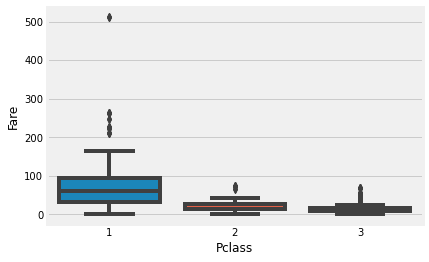

In [11]:
sns.boxplot(x='Pclass', y='Fare', data=train_df);

**Finding & analysis on the summary statistics:**

The data scales of Age and Fare are much bigger than those of the rest numerical variables. The machine-learnig algorithms based on the distance measurements or gradient descent are quite sensitive to the scales, so rescaling is necessary. For tree-based algorithms, scaling is not necessary.

The minimum fare is zero, involving 15 tickets.It may indicate free tickets or missing values. [Tammy]( https://www.kaggle.com/c/titanic/discussion/10570) found the evidence about the complimentary ticket for John George. As not any evidence was found about the missing fare data marked as 0, I interpreted the value 0 as it is (free ticket).  

The maximum fare is 512, much higher than the median.Are there any outliers? They are not.As shown by the above graph, the ticket price is much related with Pclass. The high price was confirmed by several web pages - [quora](https://www.quora.com/How-much-was-the-first-class-fare-on-Titanic), [jamescamerononline](http://www.jamescamerononline.com/TitanicFAQ.htm)

In [12]:
#check the number of unique values of each columns
unique_counts = pd.DataFrame.from_records([(col, train_df[col].nunique()) for col in train_df.columns], columns=['Column_Name', 'Num_Unique']).\
                sort_values(by='Num_Unique')
unique_counts

,Column_Name,Num_Unique
1,Survived,2
4,Sex,2
2,Pclass,3
11,Embarked,3
6,SibSp,7
7,Parch,7
5,Age,88
10,Cabin,147
9,Fare,248
8,Ticket,681


**Finding:**  
Some categorical variables have 2 or 3 uniuqe values - 'Survived', 'Sex', 'Pclass', 'Embarked'.  
The other categorial variables have over 100 unique values - 'Cabin', 'Ticket', 'PassengerId', 'Name'. Each sample's ticket value is not uniuqe.

### Data distribution of numerical variables

In [13]:
#list the names of the numerical variables
cols_num = ['Age', 'SibSp', 'Parch', 'Fare']

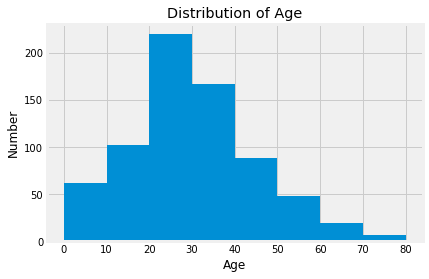

In [14]:
#check the distribution of numerical variables
plot_histogram('Age', bins=np.arange(0, 90, 10))

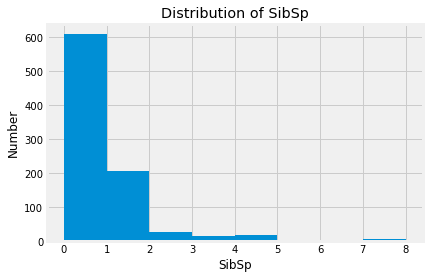

In [15]:
plot_histogram('SibSp', bins=np.arange(0,9,1))

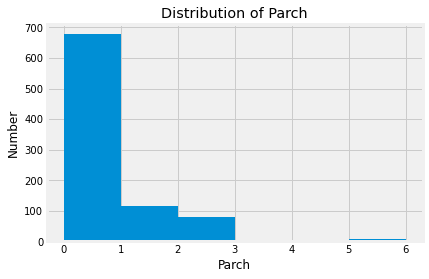

In [16]:
plot_histogram('Parch', bins=np.arange(0, 7, 1))

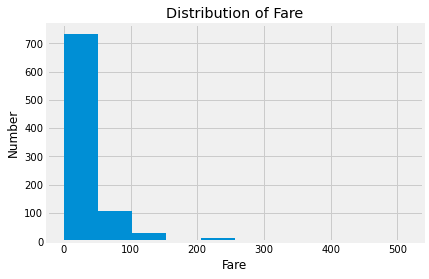

In [17]:
plot_histogram('Fare')

In [18]:
for col in cols_num:
    skewness = skew(train_df[col].dropna())
    print('Skewness of {}: {}'.format(col, round(skewness,1)))

Skewness of Age: 0.4
Skewness of SibSp: 3.7
Skewness of Parch: 2.7
Skewness of Fare: 4.8


**My analysis about the distribution of numerical variables:**

'Age': relatively normal.  
'Sibsp', 'Parch', 'Fare': not normal, right skewed.  
For 'Sibsp', 'Parch'and 'Fare'variables, replace the data with its log, square root or inverse may help remove the skewness and to minimize the extreme values' impact on the algorithms.  

### Data distribution of categorical variables

In [19]:
#List the names of the categorical columns which have fewer than 10 categories
cols_few_cat = ['Survived', 'Pclass', 'Sex', 'Embarked']
#List the names of the categorical columns which have more than 10 categories but fewer than 891 categories
cols_many_cat= ['Ticket', 'Cabin']

In [20]:
#List the value_counts of the categorical columns which have only a few categories
for col in cols_few_cat:
    print('Column Name:', col)
    print(train_df[col].value_counts(normalize=True))
    print('')

Column Name: Survived
0    0.616162
1    0.383838
Name: Survived, dtype: float64

Column Name: Pclass
3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

Column Name: Sex
male      0.647587
female    0.352413
Name: Sex, dtype: float64

Column Name: Embarked
S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64



In [21]:
#check for duplicated values, 'value' means the number of samples sharing the same value, 
for col in cols_many_cat:
    value_counts = train_df[col].value_counts()
    duplicated_value_counts = value_counts.value_counts()
    duplicated_value_counts_df = duplicated_value_counts.to_frame()
    duplicated_value_counts_df.reset_index(inplace=True)
    duplicated_value_counts_df.rename(columns={'index': 'number of duplicated samples per uniuqe value', col: 'number of unique values'}, \
                                     inplace=True)
    print('Duplicated value counts of {}'.format(col))
    print(duplicated_value_counts_df)
    print('')

Duplicated value counts of Ticket
   number of duplicated samples per uniuqe value  number of unique values
0                                              1                      547
1                                              2                       94
2                                              3                       21
3                                              4                       11
4                                              7                        3
5                                              6                        3
6                                              5                        2

Duplicated value counts of Cabin
   number of duplicated samples per uniuqe value  number of unique values
0                                              1                      101
1                                              2                       38
2                                              3                        5
3                                           

**Finding and analysis:**  
The number of the survivors is only half of that of the victims. So this is an imbalanced classfication task.
Unequal distribution was found of 'Pclass', 'Sex', 'Embarked'as well,

'Cabin' and 'Ticket' have several hundreds of categories. For most the categories, each value only appears in one sample.Some passengers sharing the same cabin can be understood. However, it's a bit suprising that some passengers are sharing the same 'Ticket' number. It takes further investigation to clarify.

### Check the relationship between Survived and other variables

#### Check how survival rates are varied by the numerical variables

In [22]:
#Compare the variation of variable values (median) by Survived
pd.pivot_table(train_df, index='Survived', values=cols_num, aggfunc=np.median)

,Age,Fare,Parch,SibSp
Survived,,,,
0,28.0,10.5,0,0
1,28.0,26.0,0,0


**Finding:**  
The median values of these numerical variables do not vary by Survived, except for Fare.

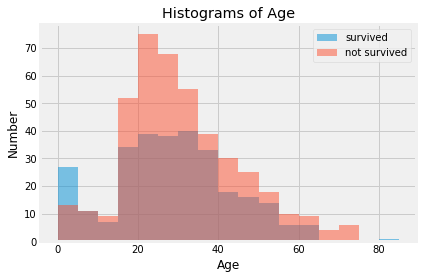

In [23]:
compare_hists('Age', bins=np.arange(0, 90, 5))

**Finding:**  
The group of age below 5 has much higher survival rates than the rest.  
Above 65, there are barely any survivors.

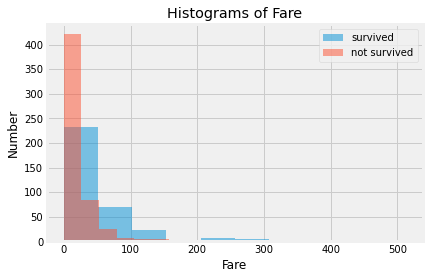

In [24]:
compare_hists('Fare')

**Finding:**  
The lowest fare group has much lower survial rates than the rest.

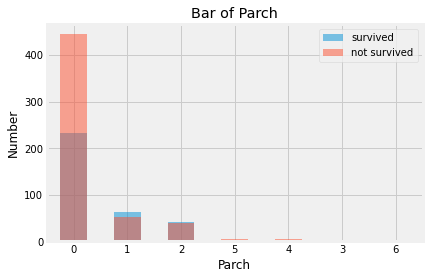

In [25]:
compare_bars('Parch')

**Finding:**  
The survival rates at Parch values f 1 and 2 are much higher than that at Parch value 0.

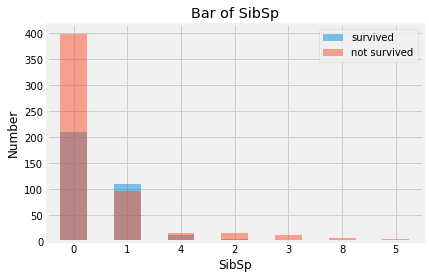

In [26]:
compare_bars('SibSp')

**Finding:**  
The survival rate at SibSp value of 1 is much higher than that at SibSp value 0.

#### Check how survival rates are varied by the categorical variables

In [27]:
#Check the categorical variables with only a few unique values
for col in cols_few_cat[1:]:
    table = pd.pivot_table(train_df, index='Survived', columns=col, values='PassengerId', aggfunc='count', margins=True)
    #print('Count:')
    #print(table)
    #print('')
    print('Survival rates (%) varied by {}:'.format(col))
    display(round(100*table.iloc[[1], :-1].div(table.iloc[-1, :-1], axis=1)))
    print('')

Survival rates (%) varied by Pclass:


Pclass,1,2,3
Survived,,,
1,63.0,47.0,24.0



Survival rates (%) varied by Sex:


Sex,female,male
Survived,,
1,74.0,19.0



Survival rates (%) varied by Embarked:


Embarked,C,Q,S
Survived,,,
1,55.0,39.0,34.0


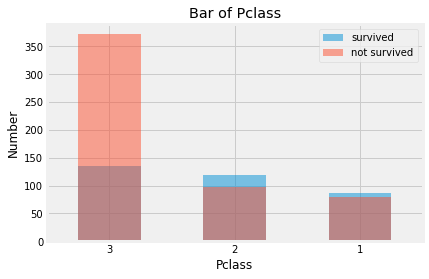

In [28]:
compare_bars('Pclass')

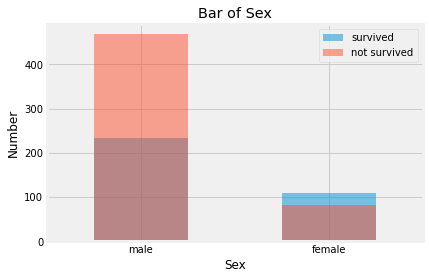

In [29]:
compare_bars('Sex')

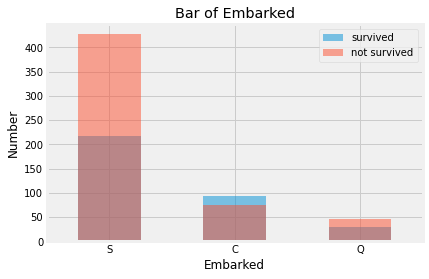

In [30]:
compare_bars('Embarked')

#### Correlation between variables
According to [Pearson Product-Moment Correlation](https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide-2.php) and [Spearman's Rank-Order Correlation](https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide-2.php) from Laerd website:   
Pearson Product-Moment Correlation is between two interval or ratio variables which are normally distributed.As all variables but 'Age' fail to meet this requirement, this method is not appliable.  
Instead, Spearman Rank-Order Correlation method is applicable here for it only requires the variables to be either ordinal, interval or ratio. This method measures the strength and direction of the monotonic relationship between two ranked variables.

In [64]:
#map the sex values to 0 and 1, and create a new column 'Is_female'
train_df['Is_female'] = train_df['Sex'].map({'female': 1, 'male': 0})
train_df.drop('Sex',axis=1,inplace=True)
features = ['Survived', 'Pclass', 'Is_female', 'Age', 'SibSp', 'Parch', 'Fare']
corr_spearman = train_df[features].corr(method='spearman')['Survived']
corr_spearman

Survived     1.000000
Pclass      -0.339668
Is_female    0.543351
Age         -0.052565
SibSp        0.086254
Parch        0.138821
Fare         0.323736
Name: Survived, dtype: float64

,Survived,Pclass,Is_female,Age,SibSp,Parch,Fare
Survived,1.00,-0.34,0.54,-0.05,0.09,0.14,0.32
Pclass,-0.34,1.00,-0.14,-0.36,-0.05,-0.02,-0.69
Is_female,0.54,-0.14,1.00,-0.08,0.19,0.26,0.26
Age,-0.05,-0.36,-0.08,1.00,-0.18,-0.25,0.14
SibSp,0.09,-0.05,0.19,-0.18,1.00,0.45,0.45
Parch,0.14,-0.02,0.26,-0.25,0.45,1.00,0.41
Fare,0.32,-0.69,0.26,0.14,0.45,0.41,1.00


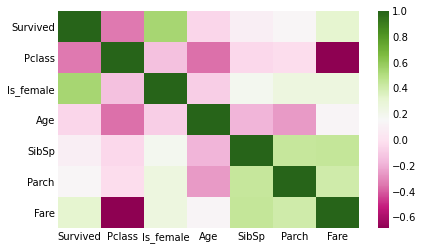

In [32]:
#use heatmap for visualization and choose contrast colors for a more clear view
display(round(train_df[features].corr(method='spearman'), 2))
sns.heatmap(train_df[features].corr(method='spearman'), cmap="PiYG");

**Finding and analysis**  
The top 3 most related variables for Survived: Is_female (0.54), Pclass (-0.33), Fare (0.32).
Among these three, Pclass and Fare are highly correlated (-0.69).  
Among all the variables, Age has the most weak correlation with Survived (-0.05), indicating very weak monotonic relationship.This doesn't necessarily mean that there's no relationship between 'Age' and 'Survived'. The above analysis shows that the children have a much higher survival rates and the elderly have a much a lower survival rates.

### Further analysis of 'Cabin' and 'Ticket'

In [33]:
#check the unique values of Cabin column
train_df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [34]:
round(train_df.loc[pd.notnull(train_df.Cabin), 'Survived'].mean(),2)

0.67

In [35]:
unique_cabin_values = train_df.Cabin.dropna().unique()
digit_only_values = []
alpha_only_values = []
long_values = [] #the cabin values of which the length is more than 4
other_values = []
for v in unique_cabin_values:
    if v.isdigit():
        digit_only_values.append(v)
    elif v.isalpha():
        alpha_only_values.append(v)
    elif len(v)>4:
        long_values.append(v)
    else:
        other_values.append(v)        

In [36]:
print('Different formats of Cabin values were found:\n')
print('Alpha-only values: {}\n'.format(alpha_only_values))
print('Long values: {}\n'.format(long_values))
print('Other values: {}\n'.format(other_values))

Different formats of Cabin values were found:

Alpha-only values: ['D', 'T']

Long values: ['C23 C25 C27', 'F G73', 'D10 D12', 'B58 B60', 'F E69', 'C22 C26', 'B57 B59 B63 B66', 'B96 B98', 'B51 B53 B55', 'F G63', 'C62 C64', 'B82 B84']

Other values: ['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'E31', 'A5', 'D26', 'C110', 'E101', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'C106', 'C65', 'E36', 'C54', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'C128', 'D37', 'B35', 'E50', 'C82', 'E10', 'E44', 'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71', 'D49', 'B5', 'B20', 

**Finding and analysis of Cabin**
1. Four formats of Cabin values  
All the 'Cabin' values start with a letter.    
Of the majority of uniuqe values, the letter is followed by a 1~3 digits.  
Of a few uniuqe Cabin values, they consist of the values of several single cabins.   
Of several uniuqe values, they consist of a letter and a cabin value.  
Only two unique values include nothing but a letter.  
     
2. Letter indicates deck  
The letter of 'Cabin' value is the indication for deck.
According to the [deck plan](http://ssmaritime.com/Titanic-3.htm), ‘Boat Deck’ was the uppermost deck on the Titanic.Deck A was just below Boat Deck, Deck B below Deck C, Deck D below Deck D...   
According to [the encyclopedia](https://www.encyclopedia-titanica.org/titanic-deckplans/), ‘F G73', 'F E69' cabinets were on Deck F. 'D' on Deck D, 'T' on Boat Deck.  
3. A suite made from djacent cabins  
'C23 C25 C27', 'D10 D12', 'B58 B60', 'C22 C26', 'B57 B59 B63 B66', 'B96 B98', 'B51 B53 B55', 'C62 C64', 'B82 B84', these cabinet values are of two or three adjacent cabins. According to [ultimatetitanic]( https://www.ultimatetitanic.com/interior-fittings), 'If a parlor suite didn't suffice, a wealthy family could purchase several first-class cabins adjacent to one another and open the interconnecting doors between the cabins to have a suite of their own'.
4. Large percentage of missingness greatly compromising Cabin's vadility    
The survival rate is 0.67 for the samples with given Cabin values. This is inconsistent with the overal survival rate (38%）. So the missingness of 'Cabin' values is related with 'Survived'. Due to the large proportion (77%) of missing values and its relation to the outcome 'Survived', the data distribution of 'Cabin' is no longer representative of the whole population. So We need to be very cautious with its usage.


2. Ticket  
Two forms of 'Ticket' values: alpha_only, the rest(including alpha, digit, some symbols.

In [37]:
#check the unique values of Ticket column
train_df.Ticket.unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

## Feature engineering

**New features created or to be created:**  
1. Cabin_null, Age_null: is the value of Cabin or Age missing? 0 = No, 1 = Yes.
2. Title_group (groups based on the titles extracted from 'Name'): described in the notebook 'Dealing with missing values'.   
3. Family_size: the number of family members on board, the addition of SibSp and Parch.  
4. 'Ticket_group_size': the sizes of the groups sharing the ticket numbers.
5. 'Last_name', 'Ori_last_name'

In [55]:
train_df['Cabin_null'] = train_df['Cabin'].isnull()
train_df['Age_null'] = train_df['Age'].isnull()

In [ ]:
full_df.loc[(full_df.Title=='Dr (female)') & (full_df.Sex == 'female')]
full_df.loc[(full_df.Title=='Dr') & (full_df.Sex == 'female'), 'Title'] = 'Dr (female)'

In [102]:
train_df['Family_size'] = train_df['SibSp'] + train_df['Parch'] + 1

In [118]:
#obtain the number of companions who are not family members

#firstly count the sizes of different groups sharing the same ticket numbers
ticket_group_sizes = train_df.groupby('Ticket').size()

#create a new feature ''ompanion_not_family'    
train_df['Ticket_group_size'] = train_df['Ticket'].apply(lambda x: ticket_group_sizes[x])
#check the distribution of this new feature
train_df['Ticket_group_size'].value_counts()

1    547
2    188
3     63
4     44
7     21
6     18
5     10
Name: Ticket_group_size, dtype: int64